In [1]:
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.read_csv('/home/daniel/Downloads/bq-results-20221017-183438-1666031719613.csv')

In [4]:
df.head(3)

,wizepair2_uuid,assay_chembl_id,standard_type,standard_change,standard_relation_1,standard_value_1,molecule_chembl_id_1,standard_relation_2,standard_value_2,molecule_chembl_id_2,fragment_md5_1,fragment_md5_2,radius
0,c96822a0e62b32823391576ea377aab7,CHEMBL4429195,EC50,increase,=,1.800000e+03,CHEMBL3326930,=,3.700000e+03,CHEMBL4461014,fd666d61cc324d263e0736ea7b591ede,5dc2f047df227356e3c17ce245f46761,3
1,c96822a0e62b32823391576ea377aab7,CHEMBL4429195,EC50,increase,=,1.800000e+03,CHEMBL3326930,=,3.700000e+03,CHEMBL4461014,3545a588a2083fc78b0cb46ba29b675e,81285f18fca69cbf7694dabada210116,1
2,b453fe578419a78489befc89f894d835,CHEMBL692992,Ki,no-change,=,3.162278e+13,CHEMBL153919,=,3.162278e+13,CHEMBL154566,9cf7b6a3fd85cea056f6b233fffe6581,612cbdcbb24abc1585f77bff1fc89694,4


In [5]:
df['molecule_chembl_num_1'] = df.molecule_chembl_id_1.str.extract('(\d+)')
df['molecule_chembl_num_2'] = df.molecule_chembl_id_2.str.extract('(\d+)')

In [6]:
def elo(df):
    
    # create a table where winner / loser is defined
    df_train = df[df.standard_change.isin(['increase', 'decrease'])].copy(deep=True)
    if df_train.empty: return None
    df_train['label'] = df_train.standard_change=='increase'
    
    # use index as timeseries
    df_train['timestamp'] = df_train[['molecule_chembl_num_1', 'molecule_chembl_num_2']].max(axis=1)
    df_train.sort_values('timestamp', inplace=True)
    
    # fit model
    model = EloEstimator(
        key1_field="fragment_md5_1",
        key2_field="fragment_md5_2",
        timestamp_field="timestamp",
        initial_time=0,
        default_k=100
    ).fit(df_train, df_train.label)
    
    # return proba
    df_train['proba'] = model.transform(df_train, output_type='prob', strict_past_data=True)
    return df_train[['wizepair2_uuid', 'proba', 'label']]
    

In [7]:
df_elo = df.groupby('assay_chembl_id').parallel_apply(elo)

In [8]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    9.999990e-07
0.1    1.452148e-01
0.5    5.000000e-01
0.9    8.551096e-01
1.0    9.999990e-01
Name: proba, dtype: float64

In [9]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.7779695879451856

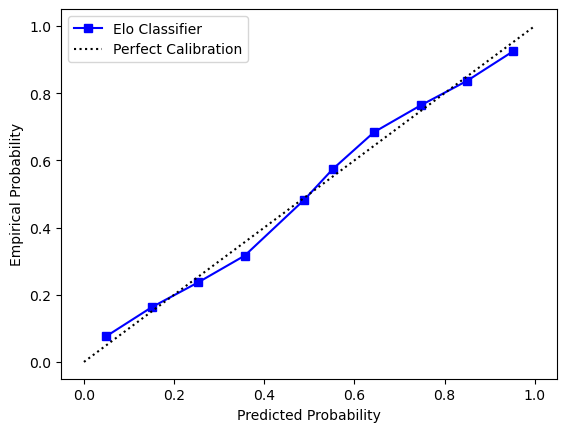

In [10]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [11]:
df_elo.to_csv('elo.csv.gz', index=False, compression='gzip')

In [12]:
def eloo(df):
    
    loo = list(pd.DataFrame())
    for mol in pd.concat([df.molecule_chembl_id_1, df.molecule_chembl_id_2]).unique():
    
        # create a table where winner / loser is defined
        df_train = df[df.standard_change.isin(['increase', 'decrease'])].copy(deep=True)
        if df_train.empty: continue
        df_train['label'] = df_train.standard_change=='increase'

        # use loo group as timeseries
        df_train['timestamp'] = ((df_train.molecule_chembl_id_1==mol) | (df_train.molecule_chembl_id_2==mol)).astype(int)
        df_train.sort_values('timestamp', inplace=True)

        # fit mode
        model = EloEstimator(
            key1_field="fragment_md5_1",
            key2_field="fragment_md5_2",
            timestamp_field="timestamp",
            initial_time=0,
            default_k=100
        ).fit(df_train, df_train.label)

        # return proba
        df_train['proba'] = model.transform(df_train, output_type='prob', strict_past_data=True)
        loo.append(df_train[df_train.timestamp==1][['wizepair2_uuid', 'proba', 'label']])

    try: return pd.concat(loo)
    except ValueError: return None

In [13]:
df_eloo = df.groupby('assay_chembl_id').parallel_apply(eloo)

In [14]:
df_eloo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    4.778036e-09
0.1    9.881159e-02
0.5    5.000000e-01
0.9    9.014727e-01
1.0    1.000000e+00
Name: proba, dtype: float64

In [15]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_eloo.label, df_eloo.proba)

0.7891176367160075

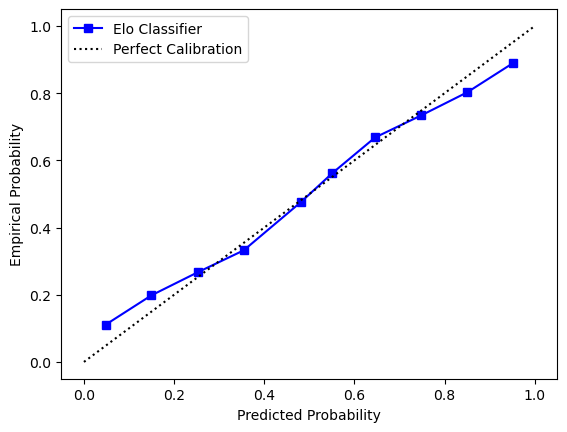

In [16]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_eloo.label,
  df_eloo.proba,
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [17]:
df_eloo.to_csv('eloo.csv.gz', index=False, compression='gzip')